## Multivariate Long Short Term Memory Neural Network
### Example from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [30]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
url= "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv"

In [7]:

from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv(url,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


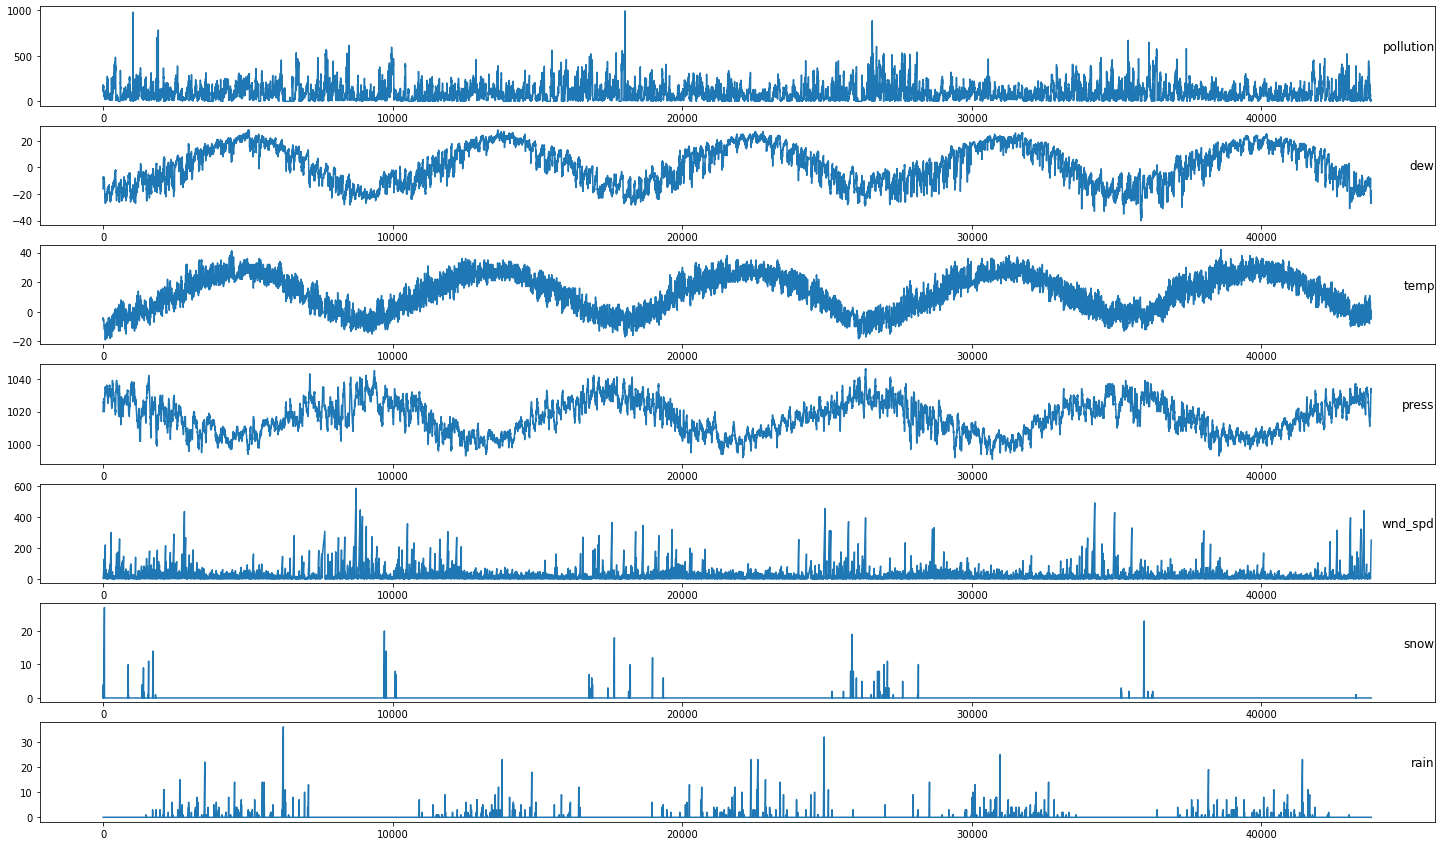

In [13]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(25,15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#Convert series to supervised
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars=1 if type(data) is list else data.shape[1]
    df= pd.DataFrame(data)
    cols, names = list(), list()
    #input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)'% (j+1, i)) for j in range(n_vars)]
    #Forecast sequence (t, t+1,..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)'% (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d'% (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg= pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
         agg.dropna(inplace=True)
    return agg

    


In [18]:
encoder= LabelEncoder()
values[:,4]= encoder.fit_transform(values[:,4])
#ensure all data is float
values= values.astype('float32')
#normalize features
scaler= MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
#frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
#drop columns we don't to predict
reframed.drop(reframed.columns[[9,10, 11,12,13,14,15]], axis=1, inplace=True)


In [19]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


In [35]:
#Split into train and test sets
values= reframed.values
n_train_hours= 365*24
train= values[:n_train_hours,:]
test = values[n_train_hours:, :]

# split into inputs and outputs
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]

#reshape input to be: samples, timesteps, features
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(8760, 1, 31) (8760,) (35037, 1, 31) (35037,)


In [23]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [27]:
# design network
model= Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

#Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72,
 validation_data= (test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 3s - loss: 0.0557 - val_loss: 0.0581 - 3s/epoch - 24ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0351 - val_loss: 0.0572 - 736ms/epoch - 6ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0222 - val_loss: 0.0452 - 807ms/epoch - 7ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0180 - val_loss: 0.0399 - 772ms/epoch - 6ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0161 - val_loss: 0.0264 - 772ms/epoch - 6ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0151 - val_loss: 0.0187 - 737ms/epoch - 6ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0150 - val_loss: 0.0173 - 846ms/epoch - 7ms/step
Epoch 8/50
122/122 - 2s - loss: 0.0149 - val_loss: 0.0167 - 2s/epoch - 13ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0150 - val_loss: 0.0156 - 678ms/epoch - 6ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0152 - 690ms/epoch - 6ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0148 - 697ms/epoch - 6ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0145 - 688ms/epoch - 6ms/step
Epoch

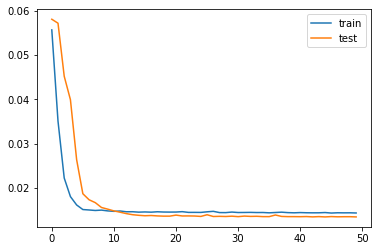

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [31]:
# Evaluate the model

yhat= model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

#invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:,1:]),axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

#invert scaling for actual
test_y = test_y.reshape(len(test_y), 1)
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y= scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#calculate RMSE
rmse= np.sqrt(mean_squared_error(inv_y, inv_yhat))

print('Test RMSE: %.3f' % rmse)


Test RMSE: 26.479


In [36]:
# Training on Multiple Lag Timesteps
# specifying the number of lag hours
n_hours =3 
n_features =8

#frame as supervised learning
reframed = series_to_supervised(scaled, n_hours,1)

In [37]:
#Split into train and test sets
values= reframed.values

train= values[:n_train_hours,:]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


In [38]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

Epoch 1/50
122/122 - 3s - loss: 0.0453 - val_loss: 0.0696 - 3s/epoch - 24ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0280 - val_loss: 0.0508 - 1s/epoch - 8ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0218 - val_loss: 0.0252 - 950ms/epoch - 8ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0208 - val_loss: 0.0223 - 941ms/epoch - 8ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0206 - val_loss: 0.0199 - 921ms/epoch - 8ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0200 - val_loss: 0.0187 - 925ms/epoch - 8ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0192 - val_loss: 0.0182 - 966ms/epoch - 8ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0188 - val_loss: 0.0182 - 941ms/epoch - 8ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0188 - val_loss: 0.0175 - 941ms/epoch - 8ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0179 - val_loss: 0.0176 - 926ms/epoch - 8ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0178 - val_loss: 0.0171 - 924ms/epoch - 8ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0173 - val_loss: 0.0170 - 914ms/epoch - 7ms/step
Epoch 

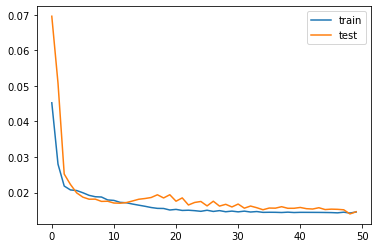

In [40]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [41]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.865


# Federated Learning Implementation from scratch

In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras import backend as K

In [2]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels


def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}



def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model
    

def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [3]:
#declear path to your mnist data folder
img_path = "/Users/daniel.bustillo/Documents/thesis/archive"

In [4]:
#get the path list using the path object
image_paths = list(paths.list_images(img_path))

In [5]:
#apply our function
image_list, label_list =load(image_paths, verbose=10000)



[INFO] processed 10000/71900
[INFO] processed 20000/71900
[INFO] processed 30000/71900
[INFO] processed 40000/71900
[INFO] processed 50000/71900
[INFO] processed 60000/71900
[INFO] processed 70000/71900


In [6]:
#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

In [7]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [8]:
#create clients
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

In [10]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

In [11]:
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

comms_round = 100

In [12]:
#create optimizer
learning_rate = 0.01 
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate==learning_rate, 
                decay=learning_rate / comms_round, 
                momentum=0.9
               ) 

In [35]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)

In [38]:
global_weights = global_model.get_weights()

In [39]:
scale_local_weight_list = []

In [51]:
client_names = [list(clients_batched.keys())]

In [53]:
random.shuffle(client_names)

In [58]:
for client in client_names:
    print(client_names[client])

AttributeError: 'list' object has no attribute 'items'

In [59]:
#loop through each client and create new local model
for client in client_names:
    smlp_local = SimpleMLP()
    local_model = smlp_local.build(784, 10)
    local_model.compile(loss=loss, 
                    optimizer=optimizer, 
                    metrics=metrics)
    #set local model weight to the weight of the global model
    local_model.set_weights(global_weights)   
    #fit local model with client's data
    local_model.fit(client, epochs=1, verbose=0)             

ValueError: in user code:

    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_9" (type Sequential).
    
    Input 0 of layer "dense_27" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=True
      • mask=None


In [ ]:
clients_batched[]

In [42]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(784, 10) 

SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)
